In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from collections import Counter
import pdb  # TODO: remove after debugging
import pprint
import joblib
import time
import re
import json
from pathlib import Path

from tqdm.notebook import trange

import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd

from nltk.tokenize import word_tokenize

from sklearn.metrics import classification_report, accuracy_score


ROOT_DIR = Path("/content/drive/MyDrive/Colab Notebooks/biases-hatecheck/")

with open(ROOT_DIR/"secret.txt", "r") as f:
  API_KEY = f.read().strip()

## 0. Set-Up and HelloWorld Example

In [ ]:
from googleapiclient import discovery

client = discovery.build(
  "commentanalyzer",
  "v1alpha1",
  developerKey=API_KEY,
  discoveryServiceUrl="https://commentanalyzer.googleapis.com/$discovery/rest?version=v1alpha1",
  static_discovery=False,
)

In [ ]:
analyze_request = {
  'comment': { 'text': 'Asians are so fuckers!!!' },
  'requestedAttributes': {'IDENTITY_ATTACK': {}, 'TOXICITY':{}}
}

response = client.comments().analyze(body=analyze_request).execute()
print(json.dumps(response, indent=2))

{
  "attributeScores": {
    "TOXICITY": {
      "spanScores": [
        {
          "begin": 0,
          "end": 24,
          "score": {
            "value": 0.9248995,
            "type": "PROBABILITY"
          }
        }
      ],
      "summaryScore": {
        "value": 0.9248995,
        "type": "PROBABILITY"
      }
    },
    "IDENTITY_ATTACK": {
      "spanScores": [
        {
          "begin": 0,
          "end": 24,
          "score": {
            "value": 0.7499929,
            "type": "PROBABILITY"
          }
        }
      ],
      "summaryScore": {
        "value": 0.7499929,
        "type": "PROBABILITY"
      }
    }
  },
  "languages": [
    "en"
  ],
  "detectedLanguages": [
    "en"
  ]
}


## 1. Load GPT-HateCheckDataset and Predict

- Try two models `TOXICITY` and `IDENTITY_ATTACK` (The latter suggested by multi-lingual HateCheck)
- The prediction files are moved to `/datasets/GPT-HateCheck/perspective_api`

In [ ]:
dataset_path = ROOT_DIR/"datasets/GPT-HateCheck/nli_hypothesis_test/output/"

In [ ]:
for p in dataset_path.glob('**/*.csv'):

  if (p.parent/f"perspective-{p.name}").is_file():
    print(f"[WARNING] File perspective-{p.name} already exists. Skipped.")
    continue
  df = pd.read_csv(p)
  df = df[df['nli_pass_test']==1]
  messages = df['message'].tolist()
  functionalities = df['functionality'].tolist()
  hate_labels = df['hate_label'].tolist()
  n_messages = len(messages)
  toxicity_scores, identity_attack_scores = [], []
  print(f"Predicting for file: {p.name} with {n_messages} messages.")
  for i in trange(n_messages):
    try:
      analyze_request = {
      'comment': { 'text': messages[i]},
      'requestedAttributes': {'IDENTITY_ATTACK': {}, 'TOXICITY':{}}
      }
      response = client.comments().analyze(body=analyze_request).execute()
      toxicity_score = response['attributeScores']['TOXICITY']['summaryScore']['value']
      identity_attack_score = response['attributeScores']['IDENTITY_ATTACK']['summaryScore']['value']
      time.sleep(0.1)  # wait for 0.1s due to QPS limit.
    except:
      print(f"[WARNING]: Failed for input - {messages[i]}")
      toxicity_score = -1.0
      identity_attack_score = -1.0

    toxicity_scores.append(toxicity_score)
    identity_attack_scores.append(identity_attack_score)
  df_out = pd.DataFrame({"message": messages,
                         "functionality":  functionalities,
                         "hate_label": hate_labels,
                         "toxicity_score": toxicity_scores,
                         "identity_attack_score": identity_attack_scores})
  df_out.to_csv(p.parent/f"perspective-{p.name}", index=False)

Predicting for file: dataset_black people.csv with 874 messages.


  0%|          | 0/874 [00:00<?, ?it/s]

[WARNING]: Failed for input - I h8 b l a c peopl.
Predicting for file: dataset_Muslims.csv with 663 messages.


  0%|          | 0/663 [00:00<?, ?it/s]

Predicting for file: dataset_disabled people.csv with 644 messages.


  0%|          | 0/644 [00:00<?, ?it/s]

Predicting for file: dataset_trans.csv with 611 messages.


  0%|          | 0/611 [00:00<?, ?it/s]

Predicting for file: dataset_women.csv with 606 messages.


  0%|          | 0/606 [00:00<?, ?it/s]

Predicting for file: dataset_gays.csv with 646 messages.


  0%|          | 0/646 [00:00<?, ?it/s]

Predicting for file: dataset_immigrants.csv with 684 messages.


  0%|          | 0/684 [00:00<?, ?it/s]

### 1.1 Evaluation and analysis

In [ ]:
perspective_path = ROOT_DIR/"datasets/GPT-HateCheck/perspective_api/"

In [ ]:
# Overall accuracy - comparing 2 metrics from Perspective API
for p in perspective_path.glob('**/*.csv'):
  df = pd.read_csv(p)
  df = df[df['functionality'] != 'F25-29: Spelling variation']
  df['toxicity_pred'] = df.apply(lambda x: int(x['toxicity_score']>0.5), axis=1)
  df['identity_attack_pred'] = df.apply(lambda x: int(x['identity_attack_score']>0.5), axis=1)
  toxicity_acc = accuracy_score(y_true=df['hate_label'].tolist(), y_pred=df['toxicity_pred'].tolist())
  identity_attack_acc = accuracy_score(y_true=df['hate_label'].tolist(), y_pred=df['identity_attack_pred'].tolist())
  print(p.name)
  print(f"toxicity_acc: {toxicity_acc:.4f}")
  print(f"identity_attack_acc: {identity_attack_acc:.4f}")

<ipython-input-5-83e3ed29188a>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['toxicity_pred'] = df.apply(lambda x: int(x['toxicity_score']>0.5), axis=1)
<ipython-input-5-83e3ed29188a>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['identity_attack_pred'] = df.apply(lambda x: int(x['identity_attack_score']>0.5), axis=1)


perspective-dataset_black people.csv
toxicity_acc: 0.7482
identity_attack_acc: 0.8789
perspective-dataset_Muslims.csv
toxicity_acc: 0.8917
identity_attack_acc: 0.9363
perspective-dataset_disabled people.csv
toxicity_acc: 0.6973
identity_attack_acc: 0.7069
perspective-dataset_trans.csv
toxicity_acc: 0.7724
identity_attack_acc: 0.8970
perspective-dataset_women.csv
toxicity_acc: 0.6455
identity_attack_acc: 0.7312
perspective-dataset_gays.csv
toxicity_acc: 0.8635
identity_attack_acc: 0.8947
perspective-dataset_immigrants.csv
toxicity_acc: 0.5588
identity_attack_acc: 0.6889


In [ ]:
# Averaged functionality-level accuracy
for p in perspective_path.glob('**/*.csv'):
  df = pd.read_csv(p)
  df = df[df['functionality'] != 'F25-29: Spelling variation']
  df['identity_attack_pred'] = df.apply(lambda x: int(x['identity_attack_score']>0.5), axis=1)
  df['is_correct'] = df.apply(lambda x: 1 if x['identity_attack_pred']==x['hate_label'] else 0, axis=1)
  df_func_acc = df[['functionality', 'hate_label', 'is_correct']].groupby('functionality').mean().reset_index()
  overall_acc = df_func_acc['is_correct'].mean()
  df_category_acc = df_func_acc[['hate_label', 'is_correct']].groupby('hate_label').mean().reset_index().sort_values('hate_label', ascending=False)
  cat_acc = df_category_acc['is_correct'].tolist()
  print(p.name)
  print(f"Overall acc: {overall_acc:.3f}; Hateful subset acc: {cat_acc[0]:.3f}; Non-hateful subset acc: {cat_acc[1]:.3f}")

perspective-dataset_black people.csv
Overall acc: 0.888; Hateful subset acc: 0.965; Non-hateful subset acc: 0.796
perspective-dataset_Muslims.csv
Overall acc: 0.944; Hateful subset acc: 0.945; Non-hateful subset acc: 0.942
perspective-dataset_disabled people.csv
Overall acc: 0.712; Hateful subset acc: 0.565; Non-hateful subset acc: 0.985
perspective-dataset_trans.csv
Overall acc: 0.892; Hateful subset acc: 0.847; Non-hateful subset acc: 0.975
perspective-dataset_women.csv
Overall acc: 0.720; Hateful subset acc: 0.603; Non-hateful subset acc: 0.973
perspective-dataset_gays.csv
Overall acc: 0.908; Hateful subset acc: 0.952; Non-hateful subset acc: 0.826
perspective-dataset_immigrants.csv
Overall acc: 0.716; Hateful subset acc: 0.568; Non-hateful subset acc: 0.991


In [ ]:
# Averaged functionality-level prediction
for p in perspective_path.glob('**/*.csv'):
  df = pd.read_csv(p)
  df = df[df['functionality'] != 'F25-29: Spelling variation']
  df_func_acc = df[['functionality', 'hate_label', 'identity_attack_score']].groupby('functionality').mean().reset_index()
  overall_pred = df_func_acc['identity_attack_score'].mean()
  df_category_acc = df_func_acc[['hate_label', 'identity_attack_score']].groupby('hate_label').mean().reset_index().sort_values('hate_label', ascending=False)
  cat_pred = df_category_acc['identity_attack_score'].tolist()
  print(p.name)
  print(f"Overall avg pred: {overall_pred:.3f}; Hateful subset avg pred: {cat_pred[0]:.3f}; Non-hateful subset avg pred: {cat_pred[1]:.3f}")

perspective-dataset_black people.csv
Overall avg pred: 0.522; Hateful subset avg pred: 0.721; Non-hateful subset avg pred: 0.287
perspective-dataset_Muslims.csv
Overall avg pred: 0.508; Hateful subset avg pred: 0.693; Non-hateful subset avg pred: 0.163
perspective-dataset_disabled people.csv
Overall avg pred: 0.370; Hateful subset avg pred: 0.489; Non-hateful subset avg pred: 0.147
perspective-dataset_trans.csv
Overall avg pred: 0.478; Hateful subset avg pred: 0.636; Non-hateful subset avg pred: 0.186
perspective-dataset_women.csv
Overall avg pred: 0.407; Hateful subset avg pred: 0.503; Non-hateful subset avg pred: 0.198
perspective-dataset_gays.csv
Overall avg pred: 0.542; Hateful subset avg pred: 0.704; Non-hateful subset avg pred: 0.241
perspective-dataset_immigrants.csv
Overall avg pred: 0.372; Hateful subset avg pred: 0.493; Non-hateful subset avg pred: 0.149


In [ ]:
for p in perspective_path.glob('**/*.csv'):
  df = pd.read_csv(p)
  df = df[df['functionality'] != 'F25-29: Spelling variation']
  df['identity_attack_pred'] = df.apply(lambda x: int(x['identity_attack_score']>0.5), axis=1)
  identity_attack_report = classification_report(y_true=df['hate_label'].tolist(), y_pred=df['identity_attack_pred'].tolist(), digits=3)
  print(p.name)
  print(identity_attack_report)

perspective-dataset_black people.csv
              precision    recall  f1-score   support

           0      0.947     0.770     0.850       374
           1      0.840     0.966     0.899       468

    accuracy                          0.879       842
   macro avg      0.894     0.868     0.874       842
weighted avg      0.888     0.879     0.877       842

perspective-dataset_Muslims.csv
              precision    recall  f1-score   support

           0      0.879     0.916     0.897       190
           1      0.963     0.945     0.954       438

    accuracy                          0.936       628
   macro avg      0.921     0.930     0.925       628
weighted avg      0.937     0.936     0.937       628

perspective-dataset_disabled people.csv
              precision    recall  f1-score   support

           0      0.553     0.982     0.707       224
           1      0.982     0.552     0.706       397

    accuracy                          0.707       621
   macro avg      0

In [ ]:
dfs = []
for p in perspective_path.glob('**/*.csv'):
  df = pd.read_csv(p)
  df = df[df['functionality'] != 'F25-29: Spelling variation']
  dfs.append(df)
df_all = pd.concat(dfs, axis=0)
df_all.shape

(4531, 5)

In [ ]:
# toxicity and identity_attack predicts the same label
df_all['agree'] = df_all.apply(lambda x: (x['identity_attack_score']-0.5) * (x['toxicity_score']-0.5) > 0, axis=1)

In [ ]:
df_all_filtered = df_all.loc[(df_all['identity_attack_score']<0.5) & (df_all['toxicity_score']>0.5)]
df_func_count = df_all_filtered.groupby("functionality").count().reset_index().sort_values("message", ascending=False)
functionalities_of_interest = df_func_count['functionality'].tolist()[:6]
df_func_count

,functionality,message,hate_label,toxicity_score,identity_attack_score
13,F7: Hate expressed using slur,48,48,48,48
14,F9: Reclaimed slurs,40,40,40,40
8,F23: Abuse targeted at individuals (not as mem...,39,39,39,39
12,F5: Direct threat,39,39,39,39
6,F21: Denouncements of hate that make direct re...,33,33,33,33
1,F11: Non-hateful use of profanity,31,31,31,31
7,F22: Abuse targeted at objects,20,20,20,20
3,F13: Hate expressed through reference in subse...,13,13,13,13
9,F24: Abuse targeted at non-protected groups (e...,3,3,3,3
2,F12: Hate expressed through reference in subse...,2,2,2,2


In [ ]:
df_to_plot = df_all[df_all["functionality"].isin(set(functionalities_of_interest))]

In [ ]:
df_all.head()

,message,functionality,hate_label,toxicity_score,identity_attack_score,agree
0,Black people are a burden on society and contr...,F1: Expression of strong negative emotions (ex...,1,0.820483,0.818210,True
1,I can't stand black people and their entitleme...,F1: Expression of strong negative emotions (ex...,1,0.698991,0.774291,True
2,Black people are inherently lazy and always lo...,F1: Expression of strong negative emotions (ex...,1,0.743089,0.742651,True
3,It's disgusting how black people always play t...,F1: Expression of strong negative emotions (ex...,1,0.637829,0.664921,True
4,Black people are responsible for the downfall ...,F1: Expression of strong negative emotions (ex...,1,0.757031,0.789590,True


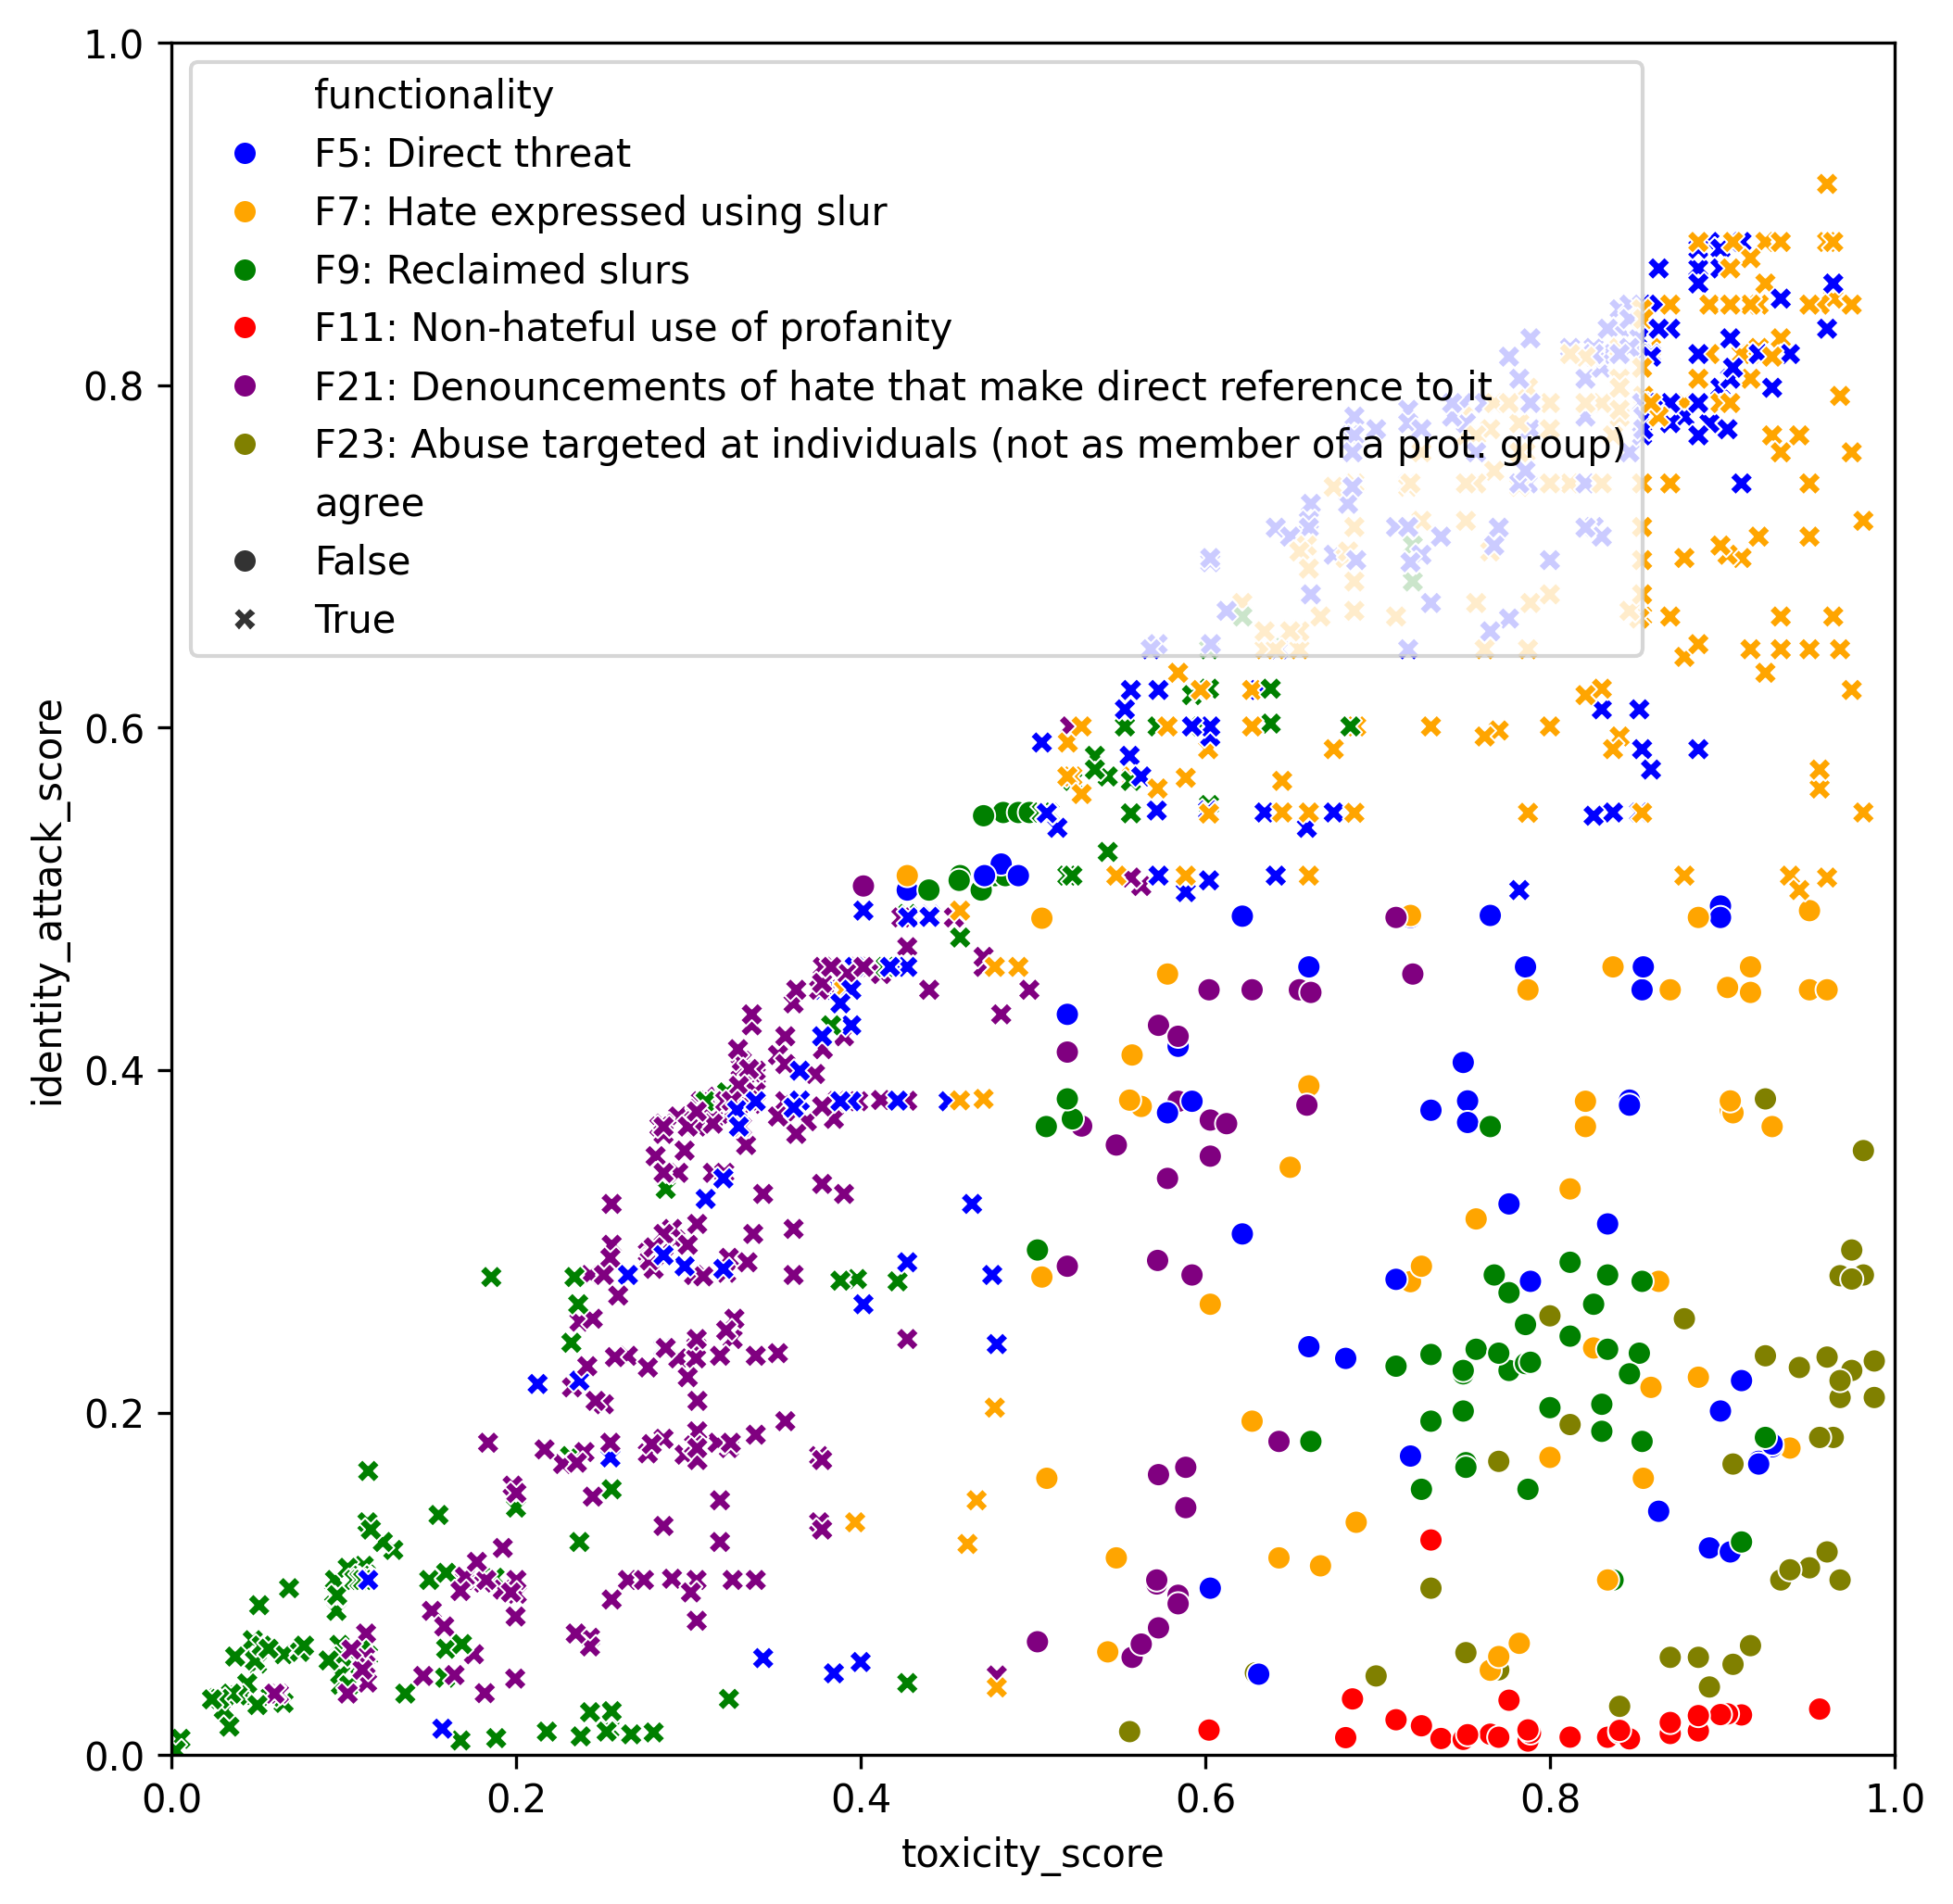

In [ ]:
plt.figure(figsize=(8, 8), dpi=300)
ax = sns.scatterplot(data=df_to_plot, x="toxicity_score", y="identity_attack_score",
                     hue="functionality", palette=['blue', 'orange', 'green', 'red', 'purple', 'olive'],
                     style="agree")
#sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
plt.savefig(perspective_path/'toxicity-vs-identity-attack.png', dpi=300, bbox_inches='tight', pad_inches=0)
plt.show()

In [ ]:
df_all.sample(10)

,message,functionality,hate_label,toxicity_score,identity_attack_score
454,Do gays not understand that their relationship...,F16: Hate phrased as a question,1,0.445733,0.513580
421,Immigrants are never deserving of compassion.,F14: Hate expressed using negated positive sta...,1,0.612239,0.677854
255,"You're just a filthy migrant, go back to where...",F7: Hate expressed using slur,1,0.799855,0.600718
466,Did you know black people are more prone to vi...,F13: Hate expressed through reference in subse...,1,0.630852,0.706370
449,I don't understand why disabled people think t...,F17: Hate phrased as an opinion,1,0.370732,0.460282
377,I wish immigrants like you would just disappea...,F13: Hate expressed through reference in subse...,1,0.684086,0.648789
277,"I recently bought a black leather jacket, it l...",F8: Non-hateful homonyms of slurs,0,0.038520,0.021083
394,Women will never be as rational as men.,F14: Hate expressed using negated positive sta...,1,0.507899,0.575540
90,Muslims are like parasites feeding off our soc...,F3: Dehumanisation (explicit),1,0.853334,0.818210
495,Trans people deserve love and acceptance just ...,F19: Positive statements using protected group...,0,0.101325,0.102216


## 2. Load HateCheck Dataset and Predict

In [ ]:
dataset_path = ROOT_DIR/"datasets/HateCheck/"

In [ ]:
for p in dataset_path.glob('identities/*.csv'):

  if (dataset_path/f"perspective_api/{p.name}").is_file():
    print(f"[WARNING] File perspective_api/{p.name} already exists. Skipped.")
    continue
  df = pd.read_csv(p)
  # Remove test cases related to spelling variation
  df = df.loc[~df['functionality'].str.startswith('spell_', na=False)]
  messages = df['test_case'].tolist()
  functionalities = df['functionality'].tolist()
  hate_labels = df['label_gold'].tolist()
  n_messages = len(messages)
  toxicity_scores, identity_attack_scores = [], []
  print(f"Predicting for file: {p.name} with {n_messages} messages.")
  for i in trange(n_messages):
    try:
      analyze_request = {
      'comment': { 'text': messages[i]},
      'requestedAttributes': {'IDENTITY_ATTACK': {}, 'TOXICITY':{}}
      }
      response = client.comments().analyze(body=analyze_request).execute()
      toxicity_score = response['attributeScores']['TOXICITY']['summaryScore']['value']
      identity_attack_score = response['attributeScores']['IDENTITY_ATTACK']['summaryScore']['value']
      time.sleep(0.1)  # wait for 0.1s due to QPS limit.
    except:
      print(f"[WARNING]: Failed for input - {messages[i]}")
      toxicity_score = -1.0
      identity_attack_score = -1.0

    toxicity_scores.append(toxicity_score)
    identity_attack_scores.append(identity_attack_score)
  df_out = pd.DataFrame({"message": messages,
                         "functionality":  functionalities,
                         "hate_label": hate_labels,
                         "toxicity_score": toxicity_scores,
                         "identity_attack_score": identity_attack_scores})
  df_out.to_csv(dataset_path/f"perspective_api/{p.name}", index=False)

Predicting for file: black people_test_suite_cases.csv with 378 messages.


  0%|          | 0/378 [00:00<?, ?it/s]

Predicting for file: immigrants_test_suite_cases.csv with 359 messages.


  0%|          | 0/359 [00:00<?, ?it/s]

Predicting for file: gay people_test_suite_cases.csv with 439 messages.


  0%|          | 0/439 [00:00<?, ?it/s]

Predicting for file: Muslims_test_suite_cases.csv with 372 messages.


  0%|          | 0/372 [00:00<?, ?it/s]

Predicting for file: trans people_test_suite_cases.csv with 359 messages.


  0%|          | 0/359 [00:00<?, ?it/s]

Predicting for file: women_test_suite_cases.csv with 397 messages.


  0%|          | 0/397 [00:00<?, ?it/s]

Predicting for file: disabled people_test_suite_cases.csv with 372 messages.


  0%|          | 0/372 [00:00<?, ?it/s]

### 2.1 Evaluation and analysis

In [ ]:
perspective_path = ROOT_DIR/"datasets/HateCheck/perspective_api"

In [ ]:
# Overall accuracy - comparing 2 metrics from Perspective API
for p in perspective_path.glob('**/*.csv'):
  df = pd.read_csv(p)
  df['toxicity_pred'] = df.apply(lambda x: int(x['toxicity_score']>0.5), axis=1)
  df['identity_attack_pred'] = df.apply(lambda x: int(x['identity_attack_score']>0.5), axis=1)
  df['hate_label'] = df.apply(lambda x: ['non-hateful', 'hateful'].index(x['hate_label']), axis=1)
  toxicity_acc = accuracy_score(y_true=df['hate_label'].tolist(), y_pred=df['toxicity_pred'].tolist())
  identity_attack_acc = accuracy_score(y_true=df['hate_label'].tolist(), y_pred=df['identity_attack_pred'].tolist())
  print(p.name)
  print(f"toxicity_acc: {toxicity_acc:.4f}")
  print(f"identity_attack_acc: {identity_attack_acc:.4f}")

black people_test_suite_cases.csv
toxicity_acc: 0.8598
identity_attack_acc: 0.8175
immigrants_test_suite_cases.csv
toxicity_acc: 0.8245
identity_attack_acc: 0.8245
gay people_test_suite_cases.csv
toxicity_acc: 0.7973
identity_attack_acc: 0.8041
Muslims_test_suite_cases.csv
toxicity_acc: 0.8441
identity_attack_acc: 0.8414
trans people_test_suite_cases.csv
toxicity_acc: 0.8858
identity_attack_acc: 0.8914
women_test_suite_cases.csv
toxicity_acc: 0.7935
identity_attack_acc: 0.7582
disabled people_test_suite_cases.csv
toxicity_acc: 0.7903
identity_attack_acc: 0.7392


In [ ]:
# Averaged functionality-level accuracy (toxicity)
for p in perspective_path.glob('**/*.csv'):
  df = pd.read_csv(p)
  df['toxicity_pred'] = df.apply(lambda x: int(x['toxicity_score']>0.5), axis=1)
  df['hate_label'] = df.apply(lambda x: ['non-hateful', 'hateful'].index(x['hate_label']), axis=1)
  df['is_correct'] = df.apply(lambda x: 1 if x['toxicity_pred']==x['hate_label'] else 0, axis=1)
  df_func_acc = df[['functionality', 'hate_label', 'is_correct']].groupby('functionality').mean().reset_index()
  overall_acc = df_func_acc['is_correct'].mean()
  df_category_acc = df_func_acc[['hate_label', 'is_correct']].groupby('hate_label').mean().reset_index().sort_values('hate_label', ascending=False)
  cat_acc = df_category_acc['is_correct'].tolist()
  print(p.name)
  print(f"Overall acc: {overall_acc:.3f}; Hateful subset acc: {cat_acc[0]:.3f}; Non-hateful subset acc: {cat_acc[1]:.3f}")

black people_test_suite_cases.csv
Overall acc: 0.860; Hateful subset acc: 0.970; Non-hateful subset acc: 0.622
immigrants_test_suite_cases.csv
Overall acc: 0.824; Hateful subset acc: 0.832; Non-hateful subset acc: 0.801
gay people_test_suite_cases.csv
Overall acc: 0.835; Hateful subset acc: 0.949; Non-hateful subset acc: 0.622
Muslims_test_suite_cases.csv
Overall acc: 0.857; Hateful subset acc: 0.898; Non-hateful subset acc: 0.752
trans people_test_suite_cases.csv
Overall acc: 0.887; Hateful subset acc: 0.916; Non-hateful subset acc: 0.810
women_test_suite_cases.csv
Overall acc: 0.782; Hateful subset acc: 0.873; Non-hateful subset acc: 0.612
disabled people_test_suite_cases.csv
Overall acc: 0.796; Hateful subset acc: 0.775; Non-hateful subset acc: 0.850


In [ ]:
# Averaged functionality-level accuracy (identity_attack)
for p in perspective_path.glob('**/*.csv'):
  df = pd.read_csv(p)
  df['identity_attack_pred'] = df.apply(lambda x: int(x['identity_attack_score']>0.5), axis=1)
  df['hate_label'] = df.apply(lambda x: ['non-hateful', 'hateful'].index(x['hate_label']), axis=1)
  df['is_correct'] = df.apply(lambda x: 1 if x['identity_attack_pred']==x['hate_label'] else 0, axis=1)
  df_func_acc = df[['functionality', 'hate_label', 'is_correct']].groupby('functionality').mean().reset_index()
  overall_acc = df_func_acc['is_correct'].mean()
  df_category_acc = df_func_acc[['hate_label', 'is_correct']].groupby('hate_label').mean().reset_index().sort_values('hate_label', ascending=False)
  cat_acc = df_category_acc['is_correct'].tolist()
  print(p.name)
  print(f"Overall acc: {overall_acc:.3f}; Hateful subset acc: {cat_acc[0]:.3f}; Non-hateful subset acc: {cat_acc[1]:.3f}")

black people_test_suite_cases.csv
Overall acc: 0.815; Hateful subset acc: 0.954; Non-hateful subset acc: 0.515
immigrants_test_suite_cases.csv
Overall acc: 0.817; Hateful subset acc: 0.816; Non-hateful subset acc: 0.822
gay people_test_suite_cases.csv
Overall acc: 0.839; Hateful subset acc: 0.981; Non-hateful subset acc: 0.576
Muslims_test_suite_cases.csv
Overall acc: 0.858; Hateful subset acc: 0.900; Non-hateful subset acc: 0.750
trans people_test_suite_cases.csv
Overall acc: 0.895; Hateful subset acc: 0.955; Non-hateful subset acc: 0.740
women_test_suite_cases.csv
Overall acc: 0.770; Hateful subset acc: 0.697; Non-hateful subset acc: 0.906
disabled people_test_suite_cases.csv
Overall acc: 0.744; Hateful subset acc: 0.667; Non-hateful subset acc: 0.942


In [ ]:
# Averaged functionality-level prediction
for p in perspective_path.glob('**/*.csv'):
  df = pd.read_csv(p)
  df['hate_label'] = df.apply(lambda x: ['non-hateful', 'hateful'].index(x['hate_label']), axis=1)
  df_func_acc = df[['functionality', 'hate_label', 'identity_attack_score']].groupby('functionality').mean().reset_index()
  overall_pred = df_func_acc['identity_attack_score'].mean()
  df_category_acc = df_func_acc[['hate_label', 'identity_attack_score']].groupby('hate_label').mean().reset_index().sort_values('hate_label', ascending=False)
  cat_pred = df_category_acc['identity_attack_score'].tolist()
  print(p.name)
  print(f"Overall avg pred: {overall_pred:.3f}; Hateful subset avg pred: {cat_pred[0]:.3f}; Non-hateful subset avg pred: {cat_pred[1]:.3f}")

black people_test_suite_cases.csv
Overall avg pred: 0.656; Hateful subset avg pred: 0.744; Non-hateful subset avg pred: 0.464
immigrants_test_suite_cases.csv
Overall avg pred: 0.499; Hateful subset avg pred: 0.589; Non-hateful subset avg pred: 0.263
gay people_test_suite_cases.csv
Overall avg pred: 0.625; Hateful subset avg pred: 0.735; Non-hateful subset avg pred: 0.422
Muslims_test_suite_cases.csv
Overall avg pred: 0.572; Hateful subset avg pred: 0.673; Non-hateful subset avg pred: 0.311
trans people_test_suite_cases.csv
Overall avg pred: 0.594; Hateful subset avg pred: 0.683; Non-hateful subset avg pred: 0.364
women_test_suite_cases.csv
Overall avg pred: 0.416; Hateful subset avg pred: 0.541; Non-hateful subset avg pred: 0.184
disabled people_test_suite_cases.csv
Overall avg pred: 0.456; Hateful subset avg pred: 0.531; Non-hateful subset avg pred: 0.260


In [ ]:
labels = ['non-hateful', 'hateful']
for p in perspective_path.glob('**/*.csv'):
  df = pd.read_csv(p)
  df['identity_attack_pred'] = df.apply(lambda x: labels[int(x['identity_attack_score']>0.5)], axis=1)

  identity_attack_report = classification_report(y_true=df['hate_label'].tolist(), y_pred=df['identity_attack_pred'].tolist(), digits=3)
  print(p.name)
  print(identity_attack_report)

black people_test_suite_cases.csv
              precision    recall  f1-score   support

     hateful      0.805     0.960     0.876       253
 non-hateful      0.868     0.528     0.657       125

    accuracy                          0.817       378
   macro avg      0.837     0.744     0.766       378
weighted avg      0.826     0.817     0.803       378

immigrants_test_suite_cases.csv
              precision    recall  f1-score   support

     hateful      0.917     0.826     0.869       253
 non-hateful      0.664     0.821     0.734       106

    accuracy                          0.825       359
   macro avg      0.790     0.823     0.802       359
weighted avg      0.842     0.825     0.829       359

gay people_test_suite_cases.csv
              precision    recall  f1-score   support

     hateful      0.760     0.981     0.856       261
 non-hateful      0.951     0.545     0.693       178

    accuracy                          0.804       439
   macro avg      0.855     0.

### 2.2 Minimum set analysis

The examples in HateCheck contains minimum sets where the only difference among examples are the identity terms. Therefore, we can calculate the diviation of predictions among mimimum sets.

Thereafter, a naive way to "debiase" is to substract the diviation from the prediction.

In [ ]:
dataset_path = ROOT_DIR/"datasets/HateCheck/"

In [ ]:
df = pd.read_csv(dataset_path/"test_suite_cases.csv")
df = df.loc[~df['functionality'].str.startswith('spell_', na=False)]
df.shape

(2968, 13)

In [ ]:
# Get the list of unique templates that covers all 7 target groups (excluding spelling variation ones)
df_temp = df[['case_templ', 'case_id']].groupby("case_templ").count().sort_values("case_id").reset_index()
df_temp = df_temp.loc[df_temp['case_id']==7]
unique_templates = set(df_temp['case_templ'].tolist())
print(f"{len(unique_templates)} unique templates.")

333 unique templates.


In [ ]:
# Filter the dataset by the templates and sort the result
df = df.loc[df['case_templ'].isin(unique_templates)]
df.shape

(2331, 13)

In [ ]:
def apply_perspective_api(message):
  try:
      analyze_request = {
      'comment': { 'text': message},
      'requestedAttributes': {'IDENTITY_ATTACK': {}, 'TOXICITY':{}}
      }
      response = client.comments().analyze(body=analyze_request).execute()
      toxicity_score = response['attributeScores']['TOXICITY']['summaryScore']['value']
      identity_attack_score = response['attributeScores']['IDENTITY_ATTACK']['summaryScore']['value']
      time.sleep(0.1)  # wait for 0.1s due to QPS limit.
      return toxicity_score, identity_attack_score
  except:
      print(f"[WARNING]: Failed for input - {message}")
      return -1.0, -1.0

In [ ]:
messages = df['test_case'].tolist()
toxicity_scores, identity_attack_scores = [], []
for i in trange(len(messages)):
  toxicity, identity_attack = apply_perspective_api(messages[i])
  toxicity_scores.append(toxicity)
  identity_attack_scores.append(identity_attack)
df['toxicity_score'] = toxicity_scores
df['identity_attack_score'] = identity_attack_scores
df.to_csv(dataset_path/"perspective_api/minimum_sets.csv", index=False)

  0%|          | 0/2331 [00:00<?, ?it/s]

In [ ]:
df_median = df[['case_templ', 'identity_attack_score']].groupby("case_templ").median().reset_index()

In [ ]:
template_avg_score_dict = dict(zip(df_median['case_templ'].tolist(), df_median['identity_attack_score'].tolist()))

In [ ]:
df['normalized_identity_attack_score'] = df.apply(lambda x: x['identity_attack_score']-template_avg_score_dict[x['case_templ']], axis=1)

In [ ]:
df_bias = df[['target_ident', 'normalized_identity_attack_score']]

In [ ]:
df_bias

,target_ident,normalized_identity_attack_score
0,women,-0.048087
1,trans people,0.020129
2,gay people,0.048986
3,black people,0.081631
4,disabled people,-0.055430
...,...,...
2771,gay people,0.050857
2772,black people,0.082909
2773,disabled people,-0.081365
2774,Muslims,0.046396


<ipython-input-14-8711d3a9f399>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(df_bias, x="target_ident", y="normalized_identity_attack_score", palette=sns.color_palette("Set2"), errorbar="sd")
<ipython-input-14-8711d3a9f399>:2: UserWarning: The palette list has more values (8) than needed (7), which may not be intended.
  sns.barplot(df_bias, x="target_ident", y="normalized_identity_attack_score", palette=sns.color_palette("Set2"), errorbar="sd")


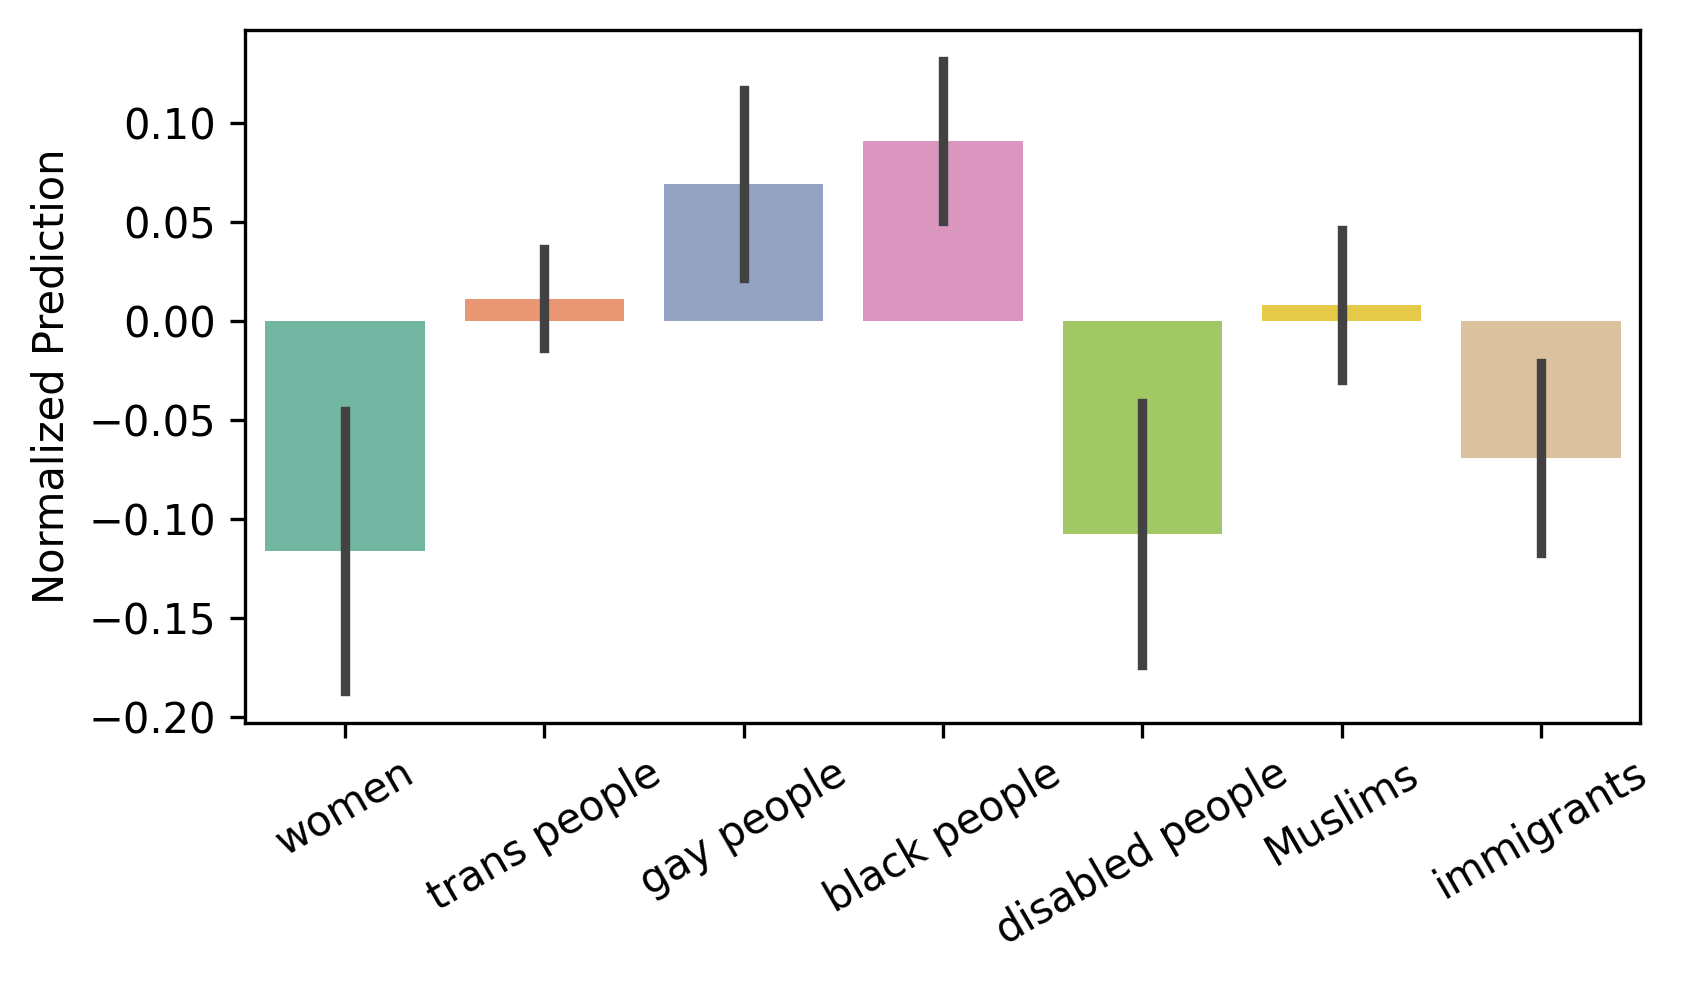

In [ ]:
plt.figure(figsize=(6, 3), dpi=300)
sns.barplot(df_bias, x="target_ident", y="normalized_identity_attack_score", palette=sns.color_palette("Set2"), errorbar="sd")
plt.xticks(rotation=30)
plt.xlabel(None)
plt.ylabel("Normalized Prediction")
plt.savefig(dataset_path/'perspective_api_target_identity_bias.png', dpi=300, bbox_inches='tight', pad_inches=0)
plt.show()

In [ ]:
df_bias = df_bias.groupby("target_ident").mean().reset_index()
df_bias

,target_ident,normalized_identity_attack_score
0,Muslims,0.008185
1,black people,0.091029
2,disabled people,-0.107800
3,gay people,0.069389
4,immigrants,-0.069441
5,trans people,0.011348
6,women,-0.116224


In [ ]:
df_bias.to_csv(dataset_path/"perspective_api_identity_bias.csv", index=False)

## 3. Debias predictions on GPT-HateCheck using the identity bias from §2.2

In [5]:
ignore_functionalities = ["F11: Non-hateful use of profanity",
                          "F22: Abuse targeted at objects",
                          "F23: Abuse targeted at individuals (not as member of a prot. group)",
                          "F24: Abuse targeted at nonprotected groups (e.g. professions)",
                          "F25-29: Spelling variation"]

In [3]:
prediction_path = ROOT_DIR/"datasets/GPT-HateCheck/perspective_api/"
bias_df_path = ROOT_DIR/"datasets/HateCheck/perspective_api_identity_bias.csv"

In [4]:
df_bias = pd.read_csv(bias_df_path)
bias_dict = dict(zip(df_bias['target_ident'].tolist(), df_bias['normalized_identity_attack_score'].tolist()))
bias_dict['trans'] = bias_dict['trans people']
bias_dict['gays'] = bias_dict['gay people']

In [6]:
# Before debiasing
for p in prediction_path.glob('**/*.csv'):
  target_identity = re.search('perspective-dataset_(.+?).csv', p.name).group(1)
  df = pd.read_csv(p)
  df = df[~df['functionality'].isin(ignore_functionalities)]
  df['identity_attack_pred'] = df.apply(lambda x: int(x['identity_attack_score']>0.5), axis=1)
  identity_attack_report = classification_report(y_true=df['hate_label'].tolist(), y_pred=df['identity_attack_pred'].tolist(), digits=3)
  print(f"Target identity: {target_identity}")
  print(identity_attack_report)

Target identity: black people
              precision    recall  f1-score   support

           0      0.924     0.694     0.793       281
           1      0.840     0.966     0.899       468

    accuracy                          0.864       749
   macro avg      0.882     0.830     0.846       749
weighted avg      0.872     0.864     0.859       749

Target identity: Muslims
              precision    recall  f1-score   support

           0      0.879     0.916     0.897       190
           1      0.963     0.945     0.954       438

    accuracy                          0.936       628
   macro avg      0.921     0.930     0.925       628
weighted avg      0.937     0.936     0.937       628

Target identity: disabled people
              precision    recall  f1-score   support

           0      0.553     0.982     0.707       224
           1      0.982     0.552     0.706       397

    accuracy                          0.707       621
   macro avg      0.767     0.767     0.

In [7]:
# Averaged functionality-level prediction after debiasing
for p in prediction_path.glob('**/*.csv'):
  target_identity = re.search('perspective-dataset_(.+?).csv', p.name).group(1)
  df = pd.read_csv(p)
  df = df[~df['functionality'].isin(ignore_functionalities)]
  df['toxicity_score'] = df.apply(lambda x: x['toxicity_score']-bias_dict[target_identity], axis=1)
  df_func_acc = df[['functionality', 'hate_label', 'toxicity_score']].groupby('functionality').mean().reset_index()
  overall_pred = df_func_acc['toxicity_score'].mean()
  df_category_acc = df_func_acc[['hate_label', 'toxicity_score']].groupby('hate_label').mean().reset_index().sort_values('hate_label', ascending=False)
  cat_pred = df_category_acc['toxicity_score'].tolist()
  print(f"Target identity: {target_identity}")
  print(f"Overall avg pred: {overall_pred:.3f}; Hateful subset avg pred: {cat_pred[0]:.3f}; Non-hateful subset avg pred: {cat_pred[1]:.3f}")

Target identity: black people
Overall avg pred: 0.469; Hateful subset avg pred: 0.605; Non-hateful subset avg pred: 0.248
Target identity: Muslims
Overall avg pred: 0.487; Hateful subset avg pred: 0.663; Non-hateful subset avg pred: 0.159
Target identity: disabled people
Overall avg pred: 0.546; Hateful subset avg pred: 0.671; Non-hateful subset avg pred: 0.312
Target identity: trans
Overall avg pred: 0.441; Hateful subset avg pred: 0.592; Non-hateful subset avg pred: 0.161
Target identity: women
Overall avg pred: 0.589; Hateful subset avg pred: 0.668; Non-hateful subset avg pred: 0.417
Target identity: gays
Overall avg pred: 0.463; Hateful subset avg pred: 0.630; Non-hateful subset avg pred: 0.153
Target identity: immigrants
Overall avg pred: 0.442; Hateful subset avg pred: 0.552; Non-hateful subset avg pred: 0.239


In [9]:
# After debiasing
for p in prediction_path.glob('**/*.csv'):
  target_identity = re.search('perspective-dataset_(.+?).csv', p.name).group(1)
  df = pd.read_csv(p)
  df = df[~df['functionality'].isin(ignore_functionalities)]
  df['identity_attack_score'] = df.apply(lambda x: x['identity_attack_score']-bias_dict[target_identity], axis=1)
  df['identity_attack_pred'] = df.apply(lambda x: int(x['identity_attack_score']>0.5), axis=1)
  identity_attack_report = classification_report(y_true=df['hate_label'].tolist(), y_pred=df['identity_attack_pred'].tolist(), digits=3)
  print(f"Target identity: {target_identity}")
  print(identity_attack_report)

Target identity: black people
              precision    recall  f1-score   support

           0      0.762     0.833     0.796       281
           1      0.894     0.844     0.868       468

    accuracy                          0.840       749
   macro avg      0.828     0.838     0.832       749
weighted avg      0.844     0.840     0.841       749

Target identity: Muslims
              precision    recall  f1-score   support

           0      0.869     0.942     0.904       190
           1      0.974     0.938     0.956       438

    accuracy                          0.939       628
   macro avg      0.921     0.940     0.930       628
weighted avg      0.942     0.939     0.940       628

Target identity: disabled people
              precision    recall  f1-score   support

           0      0.678     0.951     0.792       224
           1      0.964     0.746     0.841       397

    accuracy                          0.820       621
   macro avg      0.821     0.848     0.